# mxnet linear regression

# 1. 随机生成数据集

In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

/root/anaconda3/envs/envtf/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/envtf/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/envtf/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# generate random x1,x2 as features
num_inputs = 2 # 2 input: x1, x2
num_examples = 1000 # 1000 points
true_w = [2, -3.4] # 2 weight
true_b = 4.2 # bais
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))#标准差为1的正态分布
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)#标准差为0.01的正态分布

In [3]:
features[0], labels[0]
# features[0] is [x1,x2], label is y = x1*w1+x2*w2+b

(
 [2.2122064 0.7740038]
 <NDArray 2 @cpu(0)>, 
 [6.000587]
 <NDArray 1 @cpu(0)>)

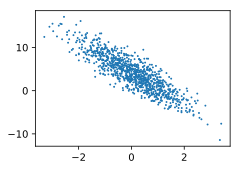

In [4]:
# display data
# x: x1, y:y
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1)

# 2. 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)  # take函数根据索引返回对应元素

In [6]:
# 测试这个函数
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[ 0.4231157   0.64803934]
 [-0.7887759   0.64921004]
 [ 1.2054669  -0.99645287]
 [-0.94586486  0.5678514 ]
 [-1.8886926   0.7965518 ]
 [-1.6575857   1.4283854 ]
 [-1.1784962   0.774073  ]
 [ 0.04370913  0.1237288 ]
 [-1.2387311   1.6483529 ]
 [-1.8871194   0.832024  ]]
<NDArray 10x2 @cpu(0)> 
[ 2.8509607   0.41422766  9.992634    0.39167407 -2.284341   -3.9651418
 -0.78432673  3.8636084  -3.8805866  -2.4121945 ]
<NDArray 10 @cpu(0)>


# 3. 初始化模型参数

In [7]:
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))

In [8]:
w.attach_grad()
b.attach_grad()

# 4. 定义模型

In [9]:
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return nd.dot(X, w) + b

# 5. 定义损失函数

In [18]:
def squared_loss(y_hat, y):  # y_hat is y_pred
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 6. 定义优化算法

In [11]:
def sgd(params, lr, batch_size):  
    for param in params:
        param[:] = param - lr * param.grad / batch_size

# 7. 训练模型

In [19]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.000050
epoch 2, loss 0.000050
epoch 3, loss 0.000050


In [13]:
print(true_w, w)
print(true_b,b)

[2, -3.4] 
[[ 1.18964  ]
 [-2.0660515]]
<NDArray 2x1 @cpu(0)>
4.2 
[2.4103951]
<NDArray 1 @cpu(0)>


# 8. 思考

1. 为什么squared_loss函数中需要使用reshape函数？

   * 首先， y.shape = (10,), y_hat.shape = (10, 1)
   * 如果不做reshape，没法进行数学计算

2. 尝试使用不同的学习率，观察损失函数值的下降快慢。

lr适中
```
lr = 0.03
epoch 1, loss 0.040544
epoch 2, loss 0.000150
epoch 3, loss 0.000050
```
lr较大
```
lr = 0.3
epoch 1, loss 0.000052
epoch 2, loss 0.000052
epoch 3, loss 0.000054
```
lr较小
```
lr = 0.003
epoch 1, loss 8.997435
epoch 2, loss 4.984050
epoch 3, loss 2.762571
```


3. 如果样本个数不能被批量大小整除，data_iter函数的行为会有什么变化？
   * 见下面测试


In [21]:
# 测试这个函数
batch_size = 150

for X, y in data_iter(batch_size, features, labels):
    print(X.shape, y.shape)

(150, 2) (150,)
(150, 2) (150,)
(150, 2) (150,)
(150, 2) (150,)
(150, 2) (150,)
(150, 2) (150,)
(100, 2) (100,)
